# Multi-Armed Bandit Basics

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl

import numba

from tqdm.notebook import tqdm

# needed for our loss plots
from IPython.display import clear_output

# using inline, have to set the figure bigger
%matplotlib inline


# set figure parameters so they look pretty
import matplotlib.pylab as pylab

# Use the Gill Sans font
import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {'legend.fontsize': 14,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20={
    'deep_blue' : (31, 119, 180), 'light_blue' : (174, 199, 232),
    'deep_orange' :  (255, 127, 14), 'light_orange' : (255, 187, 120), 
    'deep_green' :(44, 160, 44), 'light_green' : (152, 223, 138),
    'deep_red' : (214, 39, 40), 'light_red' : (255, 152, 150), 
    'deep_violet' : (148, 103, 189), 'light_violet' : (197, 176, 213), 
    'deep_brown' : (140, 86, 75), 'light_brown': (196, 156, 148), 
    'deep_pink' : (227, 119, 194), 'light_pink' : (247, 182, 210), 
    'deep_gray' : (127, 127, 127), 'light_gray' : (199, 199, 199), 
    'deep_olive' : (188, 189, 34), 'light_olive' : (219, 219, 141), 
    'deep_cyan' : (23, 190, 207), 'light_cyan' : (158, 218, 229)
}

for key in tableau20.keys():    
    r, g, b = tableau20[key]    
    tableau20[key] = (r / 255., g / 255., b / 255.)

*****
## Helper Functions

We'll need a bootstrap function to compute the uncertainty in the payout rate, and a bandit class for us to create multiple bandits

In [2]:
class Bandit:
    
    def __init__(self, payout):
        self.payout = payout
        
    def pull_arm(self):
        rand = np.random.random()
        if rand < self.payout:
            return 1
        else:
            return 0

In [3]:
@numba.jit
def bootstrap(data_set, n_bootstraps = 100):
    
    avgs = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        
        sub_sample = np.random.choice(data_set, size=len(data_set))
        avgs[i] = np.mean(sub_sample)
        
    return np.mean(avgs), np.std(avgs)

*****
## Setting Up The Bandits

For this project, we'll use the same set of bandits for the sake of comparison.

In [4]:
np.random.seed(42420)

n_bandits = 10
max_payout = .1

bandits = []
payouts = max_payout*np.random.random(n_bandits)

print(payouts)

for idx, payout in enumerate(payouts):
    bandits.append(Bandit(payout))

[0.04780135 0.0946898  0.01658636 0.00284122 0.03568278 0.08071186
 0.00010088 0.08736942 0.01602764 0.05266616]


In [5]:
# a few hyperparameters for the model

n_pulls = 5000      # the length of the run

burnoff_time = 100  # how many pulls to run at random to start to get statistics

*****
## Random Sampling

This is a brute force method for finding the highest payout from an individual bandit. Here, we will repeatedly pull a bandit at random and keep track of the individual payouts and uncertainties. We will also keep track of the cumulative payout, which is what we're trying to maximize.

In [6]:
# First set up some histories
cum_payout_hist = []

payouts_hist = {}
payouts_mean = {}
payouts_std = {}

for idx, payout in enumerate(payouts):
    payouts_hist[idx] = []
    payouts_mean[idx] = []
    payouts_std[idx] = []

In [7]:
cum_payout = 0
for idx in tqdm(range(n_pulls)):
    
    rand_idx = np.random.randint(0, n_bandits-1)
    
    payout = bandits[rand_idx].pull_arm()
    cum_payout += payout
    cum_payout_hist.append(cum_payout)
    
    payouts_hist[rand_idx].append(payout)
    
    if idx > burnoff_time:
    
        avg, std = bootstrap(np.array(payouts_hist[rand_idx]))
        payouts_mean[rand_idx].append(avg)
        payouts_std[rand_idx].append(std)


/opt/anaconda3/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


In [8]:
for key in payouts_hist.keys():
    payouts_hist[key] = np.array(payouts_hist[key])
    payouts_mean[key] = np.array(payouts_mean[key])
    payouts_std[key]  = np.array(payouts_std[key])

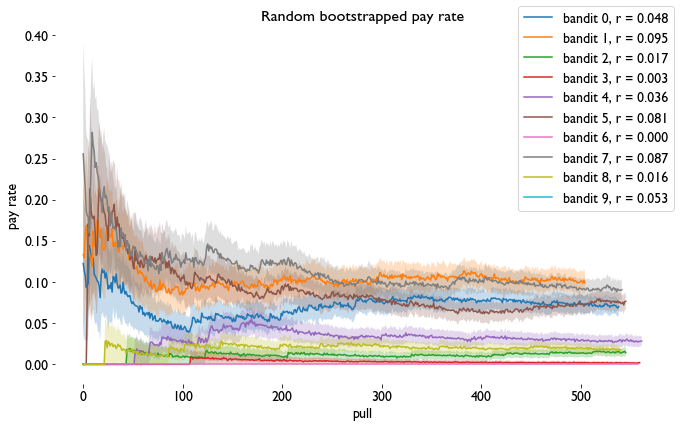

In [9]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.plot(payouts_mean[idx], label='bandit {}, r = {:.3f}'.format(idx, payouts[idx]))
    ax.fill_between(range(len(payouts_mean[idx])), payouts_mean[idx]+payouts_std[idx], payouts_mean[idx]-payouts_std[idx], alpha=.25)
ax.set_xlabel('pull')
ax.set_ylabel('pay rate')
ax.set_title('Random bootstrapped pay rate')

#ax.get_yaxis().set_major_formatter(
#        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')))

fig.legend()
fig.tight_layout()
fig.savefig('../figs/random_payrates.png')
pass;

To compare the efficacy of each approach, we will plot the total earned from our pulls against the average of all bandit payouts, which is the expected rate of return for 

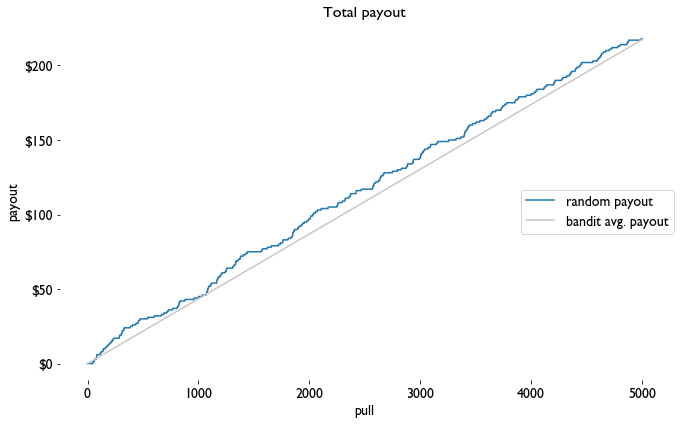

In [10]:
fig, ax = plt.subplots()

pulls = np.linspace(0, len(cum_payout_hist), len(cum_payout_hist))

ax.plot(cum_payout_hist, label='random payout')
ax.plot(np.average(payouts)*pulls, label='bandit avg. payout', c=tableau20['light_gray'])
    
ax.set_xlabel('pull')
ax.set_ylabel(r'payout')
ax.set_title('Total payout')

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')))

fig.legend(loc='center right')
fig.tight_layout()
fig.savefig('../figs/payout_random.png')
pass;

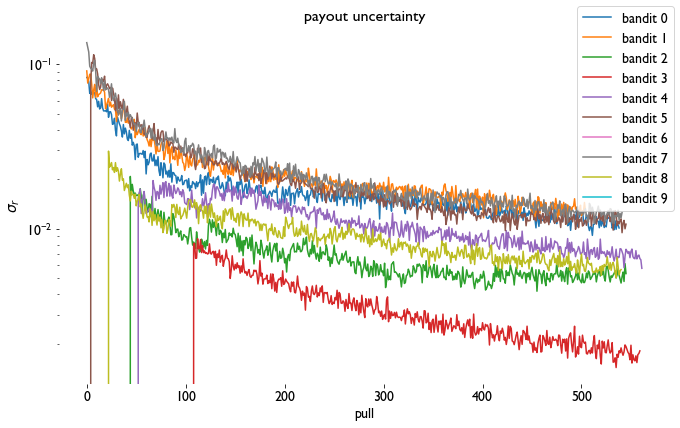

In [11]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.semilogy(payouts_std[idx], label='bandit {}'.format(idx))
    
ax.set_xlabel('pull')
ax.set_ylabel(r'$\sigma_r$')
ax.set_title('payout uncertainty')
fig.legend()
fig.tight_layout()
fig.savefig('../figs/random_uncertainty.png')
pass;

*****
## Smarter Bandit

One thing we found is that we can quickly distinguish a few of the bandits as not being optimal, and the random sampling from each evenly accomplishes one goal -- learning the payout rates of each bandit -- but does not solve our goal -- get the highest payout.

To do that, we first implement a naive dropout approach. We run each bandit to get enough measurements to start having some confidence in the results, maybe a few hundred pulls. Then we start bootstrapping the data and if a bandit becomes clearly smaller than all others, we stop pulling that bandit.

In [12]:
# First set up some histories

cum_payout_hist_dropout = []

payouts_hist = {}
payouts_mean = {}
payouts_std = {}

for idx, payout in enumerate(payouts):
    payouts_hist[idx] = []
    payouts_mean[idx] = []
    payouts_std[idx] = []

In [13]:
def check_bandits(mean, std):
    
    """Helper function to determine if any of the bandits have known payouts low enough to be discarded"""
    
    drop_bandits = []
    
    for test_key in mean.keys():
        try:
            check_bandit_low = mean[test_key][-1] + 2.*std[test_key][-1]
            drop_bandit = False

            for key in mean.keys():
                if check_bandit_low < mean[key][-1] - 2.*std[key][-1]:
                    drop_bandit = True

            if drop_bandit:
                drop_bandits.append(test_key)
        
        except:
            pass
    
    if drop_bandits:
        return drop_bandits
    else:
        return False

In [14]:
cum_payout = 0

# for keeping track of which bandits we aren't pulling anymore
dropped_bandits = []

for idx in tqdm(range(n_pulls)):
    
    rand_idx = np.random.randint(low=0, high=n_bandits-1)
    
    # keep pulling until you get a valid index
    while rand_idx in dropped_bandits:
        rand_idx = np.random.randint(0, n_bandits-1)
        
    payout = bandits[rand_idx].pull_arm()
    cum_payout += payout
    cum_payout_hist_dropout.append(cum_payout)

    payouts_hist[rand_idx].append(payout)

    avg, std = bootstrap(np.array(payouts_hist[rand_idx]))
    payouts_mean[rand_idx].append(avg)
    payouts_std[rand_idx].append(std)

    # start checking for dropped indexes
    if idx > burnoff_time:

        drop = check_bandits(payouts_mean, payouts_std)
        if drop:
            for bandit in drop:
                if bandit not in dropped_bandits:
                    dropped_bandits.append(bandit)        

In [15]:
for key in payouts_hist.keys():
    payouts_hist[key] = np.array(payouts_hist[key])
    payouts_mean[key] = np.array(payouts_mean[key])
    payouts_std[key]  = np.array(payouts_std[key])

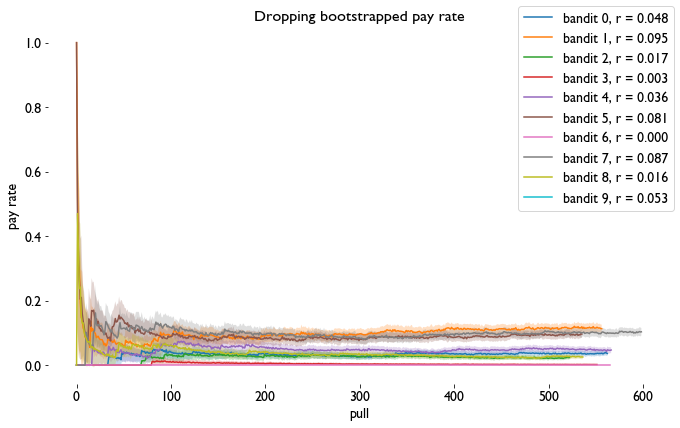

In [16]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.plot(payouts_mean[idx], label='bandit {}, r = {:.3f}'.format(idx, payouts[idx]))
    ax.fill_between(range(len(payouts_mean[idx])), payouts_mean[idx]+payouts_std[idx], payouts_mean[idx]-payouts_std[idx], alpha=.25)
ax.set_xlabel('pull')
ax.set_ylabel('pay rate')
ax.set_title('Dropping bootstrapped pay rate')
fig.legend()
fig.tight_layout()
fig.savefig('../figs/dropping_payrates.png')
pass;

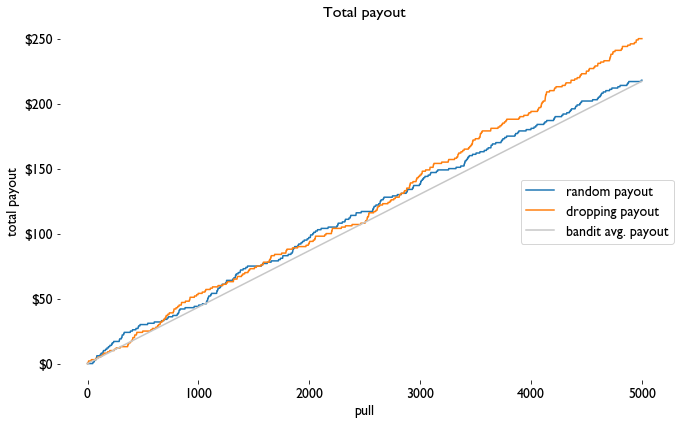

In [17]:
fig, ax = plt.subplots()

pulls = np.linspace(0, len(cum_payout_hist), len(cum_payout_hist))

ax.plot(cum_payout_hist, label='random payout')
ax.plot(cum_payout_hist_dropout, label='dropping payout')
ax.plot(np.average(payouts)*pulls, label='bandit avg. payout', c=tableau20['light_gray'])
    
ax.set_xlabel('pull')
ax.set_ylabel(r'total payout')
ax.set_title('Total payout')

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')))

fig.legend(loc='center right')
fig.tight_layout()
fig.savefig('../figs/payout_random_dropping.png')
pass;

*****
## $\varepsilon$-greedy Algorithm

Here we look for an improved version of what we did before, the $\varepsilon$-greedy algorithm. In this approach, we set a hyperparameter, $\varepsilon$, and at every pull of the arm we roll a random number from $[0,1]$. If that number is greater than $\varepsilon$, we pull the lever with the largest known $r + 2 \sigma$. If it's less, we pick an arm at random.

Like the Smarter Bandit above, this will naturally stop pulling what look to be lower-payout bandits. Unlike the Smarter Bandit, it will still give these bandits a try with some non-zero probability. This may be useful for situations with many bandits, or for bandits with time-varying payout (we'll try that in the next section). We will also use a schedule for $\varepsilon$ so that as we get more data points, we are exploring less and zeroing in more on the highest payout bandit.

In [18]:
# set up the schedule to start with 50/50 exploration and exploitation, and go to zero exploration
epsilon_schedule = np.linspace(.5, 0., n_pulls-burnoff_time)

In [19]:
def greedy_pull(epsilon, means, stds):
    
    saving_throw = np.random.random()
    
    if saving_throw > epsilon:
        return np.argmax(means+2.*stds)
    
    else: 
        return np.random.randint(n_bandits)

In [20]:
# First set up some histories

cum_payout_hist_greedy = []

payouts_hist = {}
payouts_mean = {}
payouts_std = {}

for idx, payout in enumerate(payouts):
    payouts_hist[idx] = []
    payouts_mean[idx] = []
    payouts_std[idx] = []

In [21]:
cum_payout = 0

# for keeping track of which bandits we aren't pulling anymore
dropped_bandits = []

for idx in tqdm(range(n_pulls)):
    
    if idx >= burnoff_time:
    
        epsilon = epsilon_schedule[idx-burnoff_time]
        
        means = []
        stds = []
        
        for key in payouts_mean.keys():
            means.append(payouts_mean[key][-1])
            stds.append(payouts_std[key][-1])

        pull_bandit = greedy_pull(epsilon, np.array(means), np.array(stds))
        
    else:
        pull_bandit = np.random.randint(n_bandits)
        
    payout = bandits[pull_bandit].pull_arm()
    cum_payout += payout
    cum_payout_hist_greedy.append(cum_payout)

    payouts_hist[pull_bandit].append(payout)

    avg, std = bootstrap(np.array(payouts_hist[pull_bandit]))
    payouts_mean[pull_bandit].append(avg)
    payouts_std[pull_bandit].append(std)

In [22]:
for key in payouts_hist.keys():
    payouts_hist[key] = np.array(payouts_hist[key])
    payouts_mean[key] = np.array(payouts_mean[key])
    payouts_std[key]  = np.array(payouts_std[key])

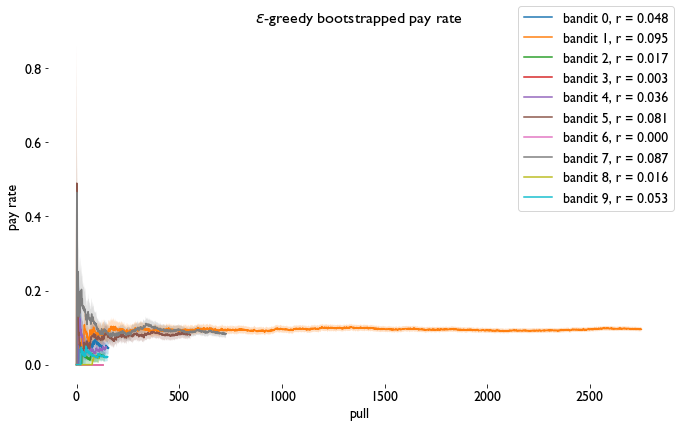

In [23]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.plot(payouts_mean[idx], label='bandit {}, r = {:.3f}'.format(idx, payouts[idx]))
    ax.fill_between(range(len(payouts_mean[idx])), payouts_mean[idx]+payouts_std[idx], payouts_mean[idx]-payouts_std[idx], alpha=.25)
ax.set_xlabel('pull')
ax.set_ylabel('pay rate')
ax.set_title(r'$\varepsilon$-greedy bootstrapped pay rate')
fig.legend()
fig.tight_layout()
fig.savefig('../figs/greedy_payrates.png')
pass;

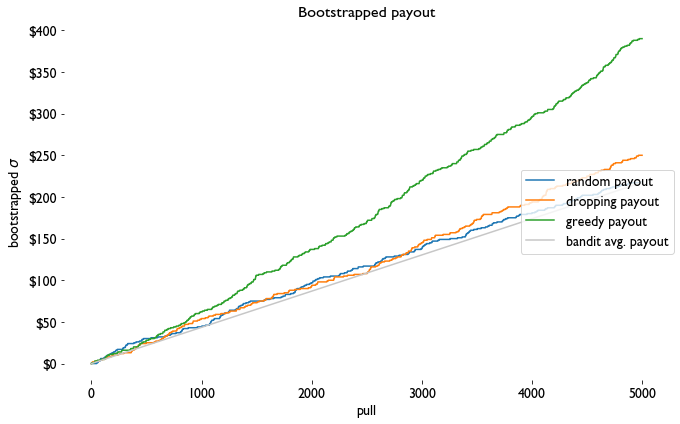

In [24]:
fig, ax = plt.subplots()

pulls = np.linspace(0, len(cum_payout_hist), len(cum_payout_hist))

ax.plot(cum_payout_hist, label='random payout')
ax.plot(cum_payout_hist_dropout, label='dropping payout')
ax.plot(cum_payout_hist_greedy, label='greedy payout')
ax.plot(np.average(payouts)*pulls, label='bandit avg. payout', c=tableau20['light_gray'])
    
ax.set_xlabel('pull')
ax.set_ylabel(r'bootstrapped $\sigma$')
ax.set_title('Bootstrapped payout')

ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$'+format(int(x), ',')))

fig.legend(loc='center right')
fig.tight_layout()
fig.savefig('../figs/payout_random_dropping_eps.png')
pass;